## 1. Introduction

Vehicle insurance fraud is a significant problem that involves false or exaggerated claims following an accident. Fraudsters may stage accidents, fabricate injuries, or engage in other deceptive practices to make claims. To address this issue, a kaggle dataset [Kaggle Dataset](<https://www.kaggle.com/datasets/shivamb/vehicle-claim-fraud-detection>) which includes information on vehicle attributes, accident details, and policy information has been used. The primary objective of this project is to develop a machine learning model that can assist insurance companies in identifying fraudulent claims. While the current focus of the notebook is specifically on the ML workflow for model development, the ultimate aim is to expose the model as a containerized API. This API will empower internal iunsurance applications and systems to detect fraudulent insurance claims.

## 2. Methodology

The project follows a typical machine learning workflow consisting of exploratory data analysis (EDA), data splitting, preprocessing, modeling, and evaluation. Additionally, a comparison of tree-based algorithms, including Logistic Regression, Support Vector Machine, and XGBoost, was performed to determine the winning model. Finally, after selecting the best model, a model interpretation analysis is conducted to gain valuable insights into the key predictors used by the fraud detection model.

## 3. Development of the Vehicle Insurance Fraud Detection ML Model

### 3.1 Import Libraries

In [31]:
# data manipulation
import pandas as pd

# mathematical functions
import numpy as np
from scipy.stats import randint, uniform
import random

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# data splitting
from sklearn.model_selection import train_test_split

# data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
import category_encoders as ce
from category_encoders import BinaryEncoder
from sklearn.feature_selection import SelectKBest, f_classif

# algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# model training requirements
import warnings
from sklearn.model_selection import RandomizedSearchCV, KFold

# model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# model persistance and loading
import os
import joblib
from joblib import dump, load

### 3.2 Data Collection

This dataset contains Time-related features, Policy and vehicle-related features, and Accident-related features to detect fraudulent claims.

In [32]:
# gathering dataset for building prediction model
df = pd.read_csv("C:/Users/aswin/Aswin's Data Science Portfolio/Vehicle-Insurance-Fraud-Detection-API/data/fraud_oracle.csv")

# remove spaces in columns name
df.columns = df.columns.str.replace(' ','_')

# print shape of df
print("The shape of df:", df.shape)

df.head()

The shape of df: (15420, 33)


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [34]:
def print_summary(df):
    # Get numerical columns
    numerical_cols = df.select_dtypes(include=['int', 'float']).columns

    # Print range of numerical values
    for col in numerical_cols:
        col_range = df[col].max() - df[col].min()
        print(f"{col}: {df[col].min()} - {df[col].max()} (Range: {col_range})")

    # Get categorical columns
    categorical_cols = df.select_dtypes(include='object').columns

    # Print unique categories in each categorical column
    for col in categorical_cols:
        unique_categories = df[col].unique()
        print(f"{col}: {unique_categories}")

print_summary(df)

WeekOfMonth: 1 - 5 (Range: 4)
WeekOfMonthClaimed: 1 - 5 (Range: 4)
Age: 0 - 80 (Range: 80)
FraudFound_P: 0 - 1 (Range: 1)
PolicyNumber: 1 - 15420 (Range: 15419)
RepNumber: 1 - 16 (Range: 15)
Deductible: 300 - 700 (Range: 400)
DriverRating: 1 - 4 (Range: 3)
Year: 1994 - 1996 (Range: 2)
Month: ['Dec' 'Jan' 'Oct' 'Jun' 'Feb' 'Nov' 'Apr' 'Mar' 'Aug' 'Jul' 'May' 'Sep']
DayOfWeek: ['Wednesday' 'Friday' 'Saturday' 'Monday' 'Tuesday' 'Sunday' 'Thursday']
Make: ['Honda' 'Toyota' 'Ford' 'Mazda' 'Chevrolet' 'Pontiac' 'Accura' 'Dodge'
 'Mercury' 'Jaguar' 'Nisson' 'VW' 'Saab' 'Saturn' 'Porche' 'BMW' 'Mecedes'
 'Ferrari' 'Lexus']
AccidentArea: ['Urban' 'Rural']
DayOfWeekClaimed: ['Tuesday' 'Monday' 'Thursday' 'Friday' 'Wednesday' 'Saturday' 'Sunday'
 '0']
MonthClaimed: ['Jan' 'Nov' 'Jul' 'Feb' 'Mar' 'Dec' 'Apr' 'Aug' 'May' 'Jun' 'Sep' 'Oct'
 '0']
Sex: ['Female' 'Male']
MaritalStatus: ['Single' 'Married' 'Widow' 'Divorced']
Fault: ['Policy Holder' 'Third Party']
PolicyType: ['Sport - Liability' 'Spor

##### Feature Recognition

This sub-section aims to improve the feature recognition process. It involves:

 1. Identifying the target feature - The feature that the model aims to predict.
 
 <br>
 
 2. Grouping input features - The input features are grouped into different categories based on their data type or characteristics, including:

   - All features: inlcludes all the input features
   
   - Numeric features: features that represent numerical values such as age, price, days, etc.

   - Categorical features: features that represent discrete values such as make, policy type, marital status, etc.
    
       - Binary features: features that represent only two possible values such as police report filed, witness present, etc.

       - Ordinal features: categorical features that have a natural order such as driver rating.

       - Nominal features: categorical features that have no natural order such as make, agent type, etc.

       - High cardinality features: categorical features that have a large number of unique values such as policy number.
    
By grouping the features into different categories, it can help to identify which features may require additional preprocessing or encoding to be used effectively in a model. It can also help to guide the feature engineering process and the feature selection process.


In [3]:
# -----TARGET SELECTION-----

# Output Feature
target_feature = 'FraudFound_P'
print("Target Feature: \n", target_feature)
print()



# -----INPUT FEATURE RECOGNITION-----


# -----all features-----
all_features = df.columns.to_list()
all_features.remove(target_feature)
print('All Features: \n', all_features)
print()


# -----numeric features-----
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'object' and df[feature].dtype !='datetime64[ns]']
numeric_features.remove(target_feature)
print('Numeric Features: \n', numeric_features)
print()


# -----categorical features-----
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'object']
print('Categorical Features: \n', categorical_features)
print()


# -----binary features-----
binary_features = ['AccidentArea', 'Sex', 'Fault', 'PoliceReportFiled', 'WitnessPresent', 'AgentType']
print('Binary Features: \n', binary_features)
print()


# -----ordinal features-----
ordinal_features = ['VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 
                    'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars']
print('Ordinal Features: \n', ordinal_features)
print()


# -----nominal features-----
nominal_features = ['Month', 'DayOfWeek', 'Make', 'DayOfWeekClaimed', 'MonthClaimed', 'MaritalStatus', 'PolicyType',
                   'VehicleCategory', 'BasePolicy']
print('Nominal Features: ', nominal_features)
print()


# -----high cardinality features-----

# Set the threshold for high cardinality
threshold = 7

# Calculate the number of unique values in each column
cardinality = df.nunique()

# Select the columns where the number of unique values is greater than the threshold
high_cardinality_features = cardinality[cardinality > threshold].index.tolist()

print('High cardinality features: ', high_cardinality_features)
print()

Target Feature: 
 FraudFound_P

All Features: 
 ['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex', 'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year', 'BasePolicy']

Numeric Features: 
 ['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'Year']

Categorical Features: 
 ['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFile

### 3.3 Exploratory Data Anlysis

EDA is conducted to gain insights into the dataset, identify patterns, and understand the relationships between attributes and insurance charges. This analysis provides valuable information for model building.

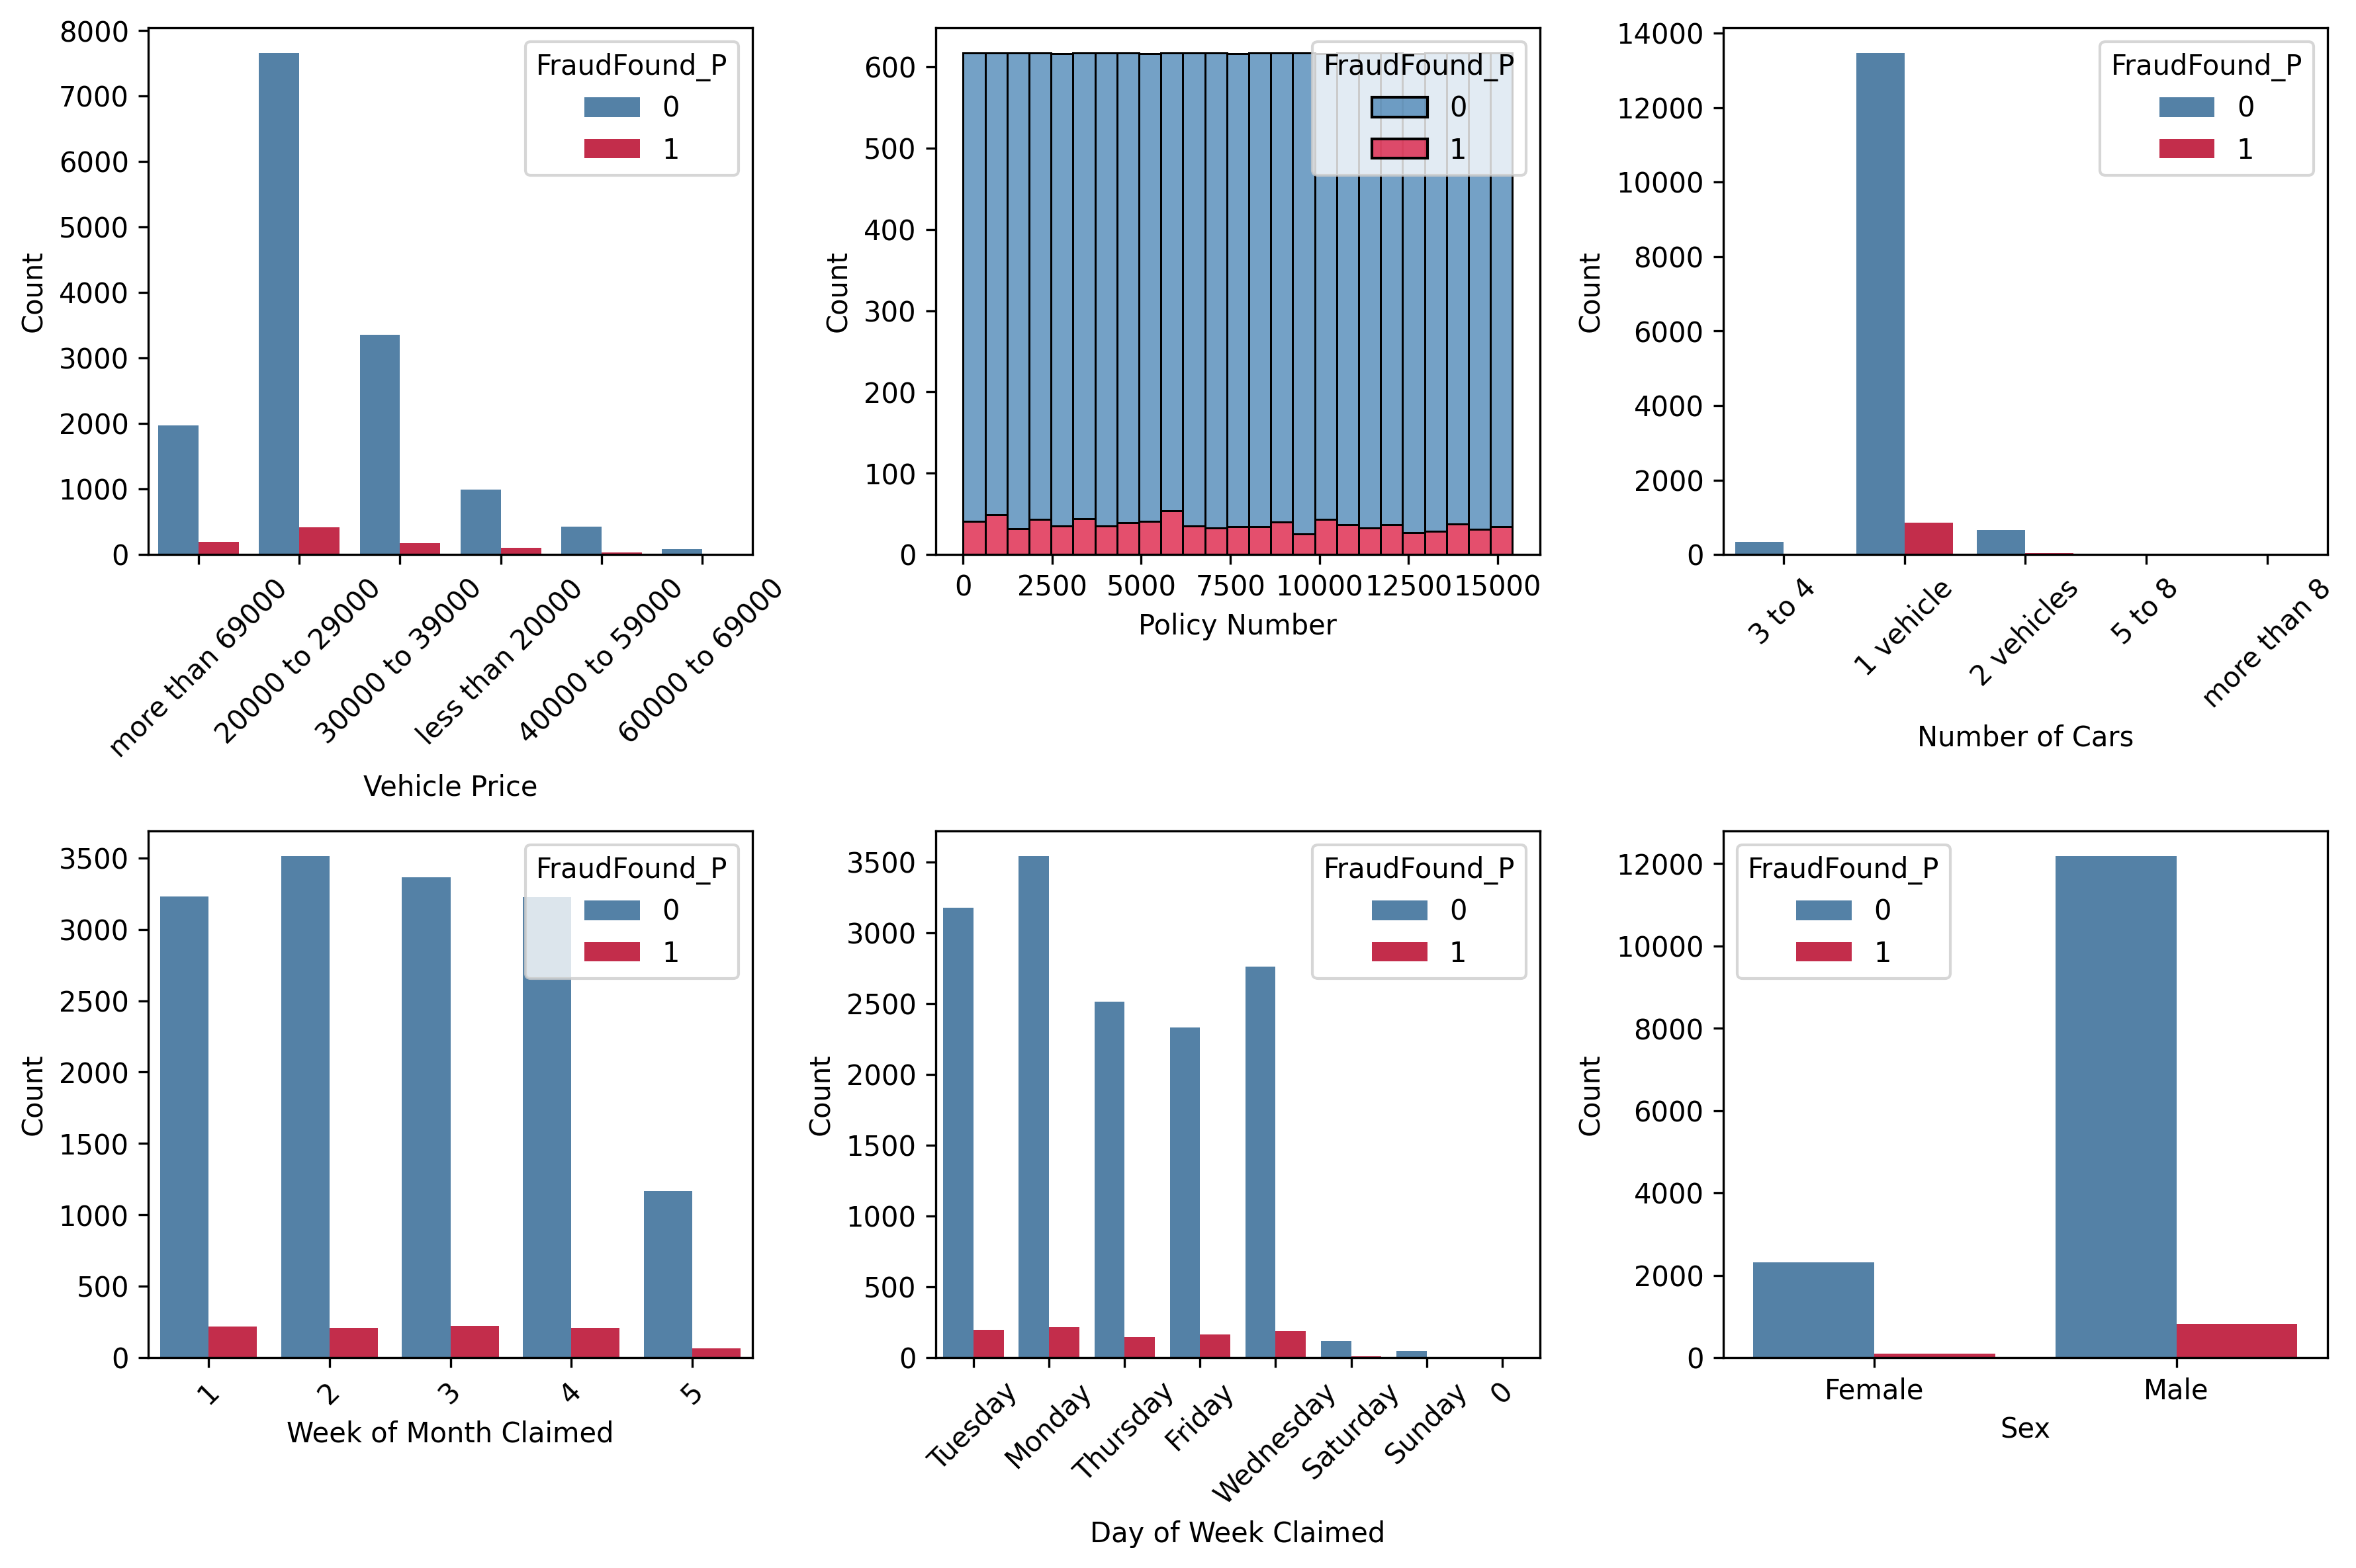

In [4]:
# Subset the required columns
subset_columns = ['VehiclePrice', 'PolicyNumber', 'NumberOfCars', 'WeekOfMonthClaimed', 'DayOfWeekClaimed', 'Sex', 'FraudFound_P']
subset_df = df[subset_columns]

# Set the color palette
colors = ["steelblue", "crimson"]

# Set the figure size and resolution
fig, axes = plt.subplots(2, 3, figsize=(12, 8), dpi=300)

# Vehicle Price
sns.countplot(ax=axes[0, 0], data=subset_df, x="VehiclePrice", hue="FraudFound_P", palette=colors)
axes[0, 0].set_xlabel("Vehicle Price")
axes[0, 0].set_ylabel("Count")
axes[0, 0].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels

# Policy Number histogram
sns.histplot(ax=axes[0, 1], data=subset_df, x="PolicyNumber", hue="FraudFound_P", multiple="stack", palette=colors)
axes[0, 1].set_xlabel("Policy Number")
axes[0, 1].set_ylabel("Count")

# Number of Cars
sns.countplot(ax=axes[0, 2], data=subset_df, x="NumberOfCars", hue="FraudFound_P", palette=colors)
axes[0, 2].set_xlabel("Number of Cars")
axes[0, 2].set_ylabel("Count")
axes[0, 2].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels

# Week of Month Claimed
sns.countplot(ax=axes[1, 0], data=subset_df, x="WeekOfMonthClaimed", hue="FraudFound_P", palette=colors)
axes[1, 0].set_xlabel("Week of Month Claimed")
axes[1, 0].set_ylabel("Count")
axes[1, 0].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels

# Day of Week Claimed
sns.countplot(ax=axes[1, 1], data=subset_df, x="DayOfWeekClaimed", hue="FraudFound_P", palette=colors)
axes[1, 1].set_xlabel("Day of Week Claimed")
axes[1, 1].set_ylabel("Count")
axes[1, 1].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels

# Sex
sns.countplot(ax=axes[1, 2], data=subset_df, x="Sex", hue="FraudFound_P", palette=colors)
axes[1, 2].set_xlabel("Sex")
axes[1, 2].set_ylabel("Count")

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


### 3.4 Data Splitting

Data splitting into train, validation, and test sets is important for machine learning to ensure the model's performance is evaluated on unseen data and to avoid overfitting. Stratifying the y variable is important to preserve the distribution of the target variable in each set, especially for imbalanced datasets. For the size of the dataset used in this project, stratification ensures representative data is used for training, validation, and testing, leading to accurate model performance evaluation. 

In [5]:
# Assign input features (also for feature selection)
X = df[['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy']]

# Assign Target Feature
y = df[target_feature]


# Perform stratified train_val-test split for input features
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, stratify= y_train_val, random_state=0)


# Print shapes of the datasets
print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of X_val: ', X_val.shape)
print('Shape of y_val: ', y_val.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)
print()

# Dataset Splitting Summary
total_samples = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

train_percent =  X_train.shape[0] / total_samples * 100
val_percent = X_val.shape[0] / total_samples * 100
test_percent = X_test.shape[0] / total_samples * 100

print(f"Training set percentage: {train_percent:.2f}%")
print(f"Validation set percentage: {val_percent:.2f}%")
print(f"Test set percentage: {test_percent:.2f}%")

Shape of X_train:  (9252, 32)
Shape of y_train:  (9252,)
Shape of X_val:  (2313, 32)
Shape of y_val:  (2313,)
Shape of X_test:  (3855, 32)
Shape of y_test:  (3855,)

Training set percentage: 60.00%
Validation set percentage: 15.00%
Test set percentage: 25.00%


### 3.5 Data Preprocessing

Data preprocessing involves several steps, including encoding categorical variables, and scaling numerical features.

##### Feature Engineering

Feature encoding is crucial for machine learning modeling. In my approach, I utilized different encoding techniques such as count encoder for high cardinality features, binary encoder for binary features, ordinal encoding for ordinal features, and one hot encoder for nominal features to preprocess the features for improved model performance.

In [6]:
# Create an instance of CountEncoder 
c_encoder = ce.CountEncoder()

# get updated high cardinality feature names
high_cardinality_features = np.intersect1d(high_cardinality_features, X.columns)

# fit_transform object on train set and transform on test set
X_train_c_encoded, X_val_c_encoded, X_test_c_encoded = c_encoder.fit_transform(X_train[high_cardinality_features]), c_encoder.transform(X_val[high_cardinality_features]), c_encoder.transform(X_test[high_cardinality_features])

In [7]:
# Create an instance of BinaryEncoder
b_encoder = BinaryEncoder()

# get updated binary feature names
binary_features = np.intersect1d(binary_features, X.columns)

# fit_transform object on train set and transform on test set
X_train_b_encoded, X_val_b_encoded, X_test_b_encoded = b_encoder.fit_transform(X_train[binary_features]), b_encoder.transform(X_val[binary_features]), b_encoder.transform(X_test[binary_features])

In [8]:
# specify the order of categories for each feature
categories = [
    ['less than 20000', '20000 to 29000', '30000 to 39000', '40000 to 59000', '60000 to 69000', 'more than 69000' ], # VehiclePrice
    ['none', '1 to 7', '8 to 15', '15 to 30', 'more than 30'], # Days_Policy_Accident
    ['none', '8 to 15' , '15 to 30', 'more than 30' ], # Days_Policy_Claim
    ['none', '1' , '2 to 4', 'more than 4'], # PastNumberOfClaims
    ['new', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', 'more than 7'], # AgeOfVehicle
    ['16 to 17',  '18 to 20', '21 to 25', '26 to 30', '31 to 35', '36 to 40', '41 to 50', '51 to 65', 'over 65'], # AgeOfPolicyHolder
    ['none', '1 to 2', '3 to 5', 'more than 5'], # NumberOfSuppliments
    ['no change', 'under 6 months', '1 year', '2 to 3 years', '4 to 8 years'], #AddressChange_Claim
    ['1 vehicle', '2 vehicles', '3 to 4', '5 to 8', 'more than 8'], # NumberOfCars    
]

# Create an instance of Ordinal Encoder
ord_encoder = OrdinalEncoder(categories=categories)

# fit_transform object on train set and transform on test set
X_train_ord_encoded, X_val_ord_encoded, X_test_ord_encoded = ord_encoder.fit_transform(X_train[ordinal_features]), ord_encoder.transform(X_val[ordinal_features]), ord_encoder.transform(X_test[ordinal_features])

# Get the names of the ordinal columns
ordinal_column_names = ordinal_features

# convert X_train_encoded, X_val_encoded, X_test_encoded numpy array to DataFrame
X_train_ord_encoded, X_val_ord_encoded, X_test_ord_encoded = pd.DataFrame(X_train_ord_encoded, columns=ordinal_column_names), pd.DataFrame(X_val_ord_encoded, columns=ordinal_column_names), pd.DataFrame(X_test_ord_encoded, columns=ordinal_column_names)

In [9]:
# Create an instance of OneHotEncoder
o_encoder = OneHotEncoder(handle_unknown = 'ignore')

# get updated nominal feature names
nominal_features = np.intersect1d(nominal_features, X.columns)

# fit_transform object on train set and transform on test set
X_train_o_encoded, X_val_o_encoded, X_test_o_encoded = o_encoder.fit_transform(X_train[nominal_features]), o_encoder.transform(X_val[nominal_features]), o_encoder.transform(X_test[nominal_features])

# Get the names of the nominal columns
nominal_column_names = o_encoder.get_feature_names_out(nominal_features)

# convert X_train_encoded, X_val_encoded, X_test_encoded to dense numpy array
X_train_o_encoded, X_val_o_encoded, X_test_o_encoded = X_train_o_encoded.toarray(), X_val_o_encoded.toarray(), X_test_o_encoded.toarray()

# convert X_train_encoded, X_val_encoded, X_test_encoded dense numpy array to DataFrame
X_train_o_encoded, X_val_o_encoded, X_test_o_encoded = pd.DataFrame(X_train_o_encoded, columns=nominal_column_names), pd.DataFrame(X_val_o_encoded, columns=nominal_column_names), pd.DataFrame(X_test_o_encoded, columns=nominal_column_names)

In [10]:
# Combine the encoded DataFrames

# Reset the index of each DataFrame
X_train_c_encoded, X_train_b_encoded, X_train_ord_encoded, X_train_o_encoded = X_train_c_encoded.reset_index(drop=True), X_train_b_encoded.reset_index(drop=True), X_train_ord_encoded.reset_index(drop=True), X_train_o_encoded.reset_index(drop=True)
X_val_c_encoded, X_val_b_encoded, X_val_ord_encoded, X_val_o_encoded = X_val_c_encoded.reset_index(drop=True), X_val_b_encoded.reset_index(drop=True), X_val_ord_encoded.reset_index(drop=True), X_val_o_encoded.reset_index(drop=True)
X_test_c_encoded, X_test_b_encoded, X_test_ord_encoded, X_test_o_encoded = X_test_c_encoded.reset_index(drop=True), X_test_b_encoded.reset_index(drop=True), X_test_ord_encoded.reset_index(drop=True), X_test_o_encoded.reset_index(drop=True)

# Combine the encoded DataFrames using pd.concat
X_train_encoded = pd.concat([X_train_c_encoded, X_train_b_encoded, X_train_ord_encoded, X_train_o_encoded], axis=1)
X_val_encoded = pd.concat([X_val_c_encoded, X_val_b_encoded, X_val_ord_encoded, X_val_o_encoded], axis=1)
X_test_encoded = pd.concat([X_test_c_encoded, X_test_b_encoded,X_test_ord_encoded, X_test_o_encoded], axis=1)

##### Feature Scaling

Numerical features are scaled using the standard scaler, ensuring that all numerical variables are transformed to have a mean of 0 and a standard deviation of 1. This normalization process enhances the performance of machine learning models and prevents features with larger scales from dominating the analysis.

In [11]:
# Create an instance of StandardScaler
scaler = StandardScaler(with_mean=False)

# fit_transform object on train set and transform on test set
X_train_scaled, X_val_scaled, X_test_scaled = scaler.fit_transform(X_train_encoded), scaler.transform(X_val_encoded), scaler.transform(X_test_encoded)

### 3.6 Model Training & Evaluation

Model training involves selecting an appropriate algorithm and fine-tuning its parameters to obtain the best possible model for a given dataset. In this case, Logistic Regression, Support Vector Machine, and XGBoost classifiers were trained and fine-tuned using random search CV with 5-fold cross-validation. The best model selected based on cross-validation performance was then trained on the entire train set and evaluated on the validation set. Once the model was optimized, it was evaluated on the test set to ensure that it generalizes well to unseen data.

##### Model definition & Hyperparameter tuning with Random Search CV

In [12]:
# define the models and hyperparameter search spaces
models = {
    'lr': {
        'model': LogisticRegression(random_state=0),
        'param_distributions': {
            # Regularization strength
            'C': np.logspace(-10, 10, 21),
            # Solver for optimization
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
            # Maximum number of iterations
            'max_iter': randint(100, 1000),
        }
    },
    
    'svc': {
        'model': SVC(random_state=0),
            'param_distributions': {
            # the type of kernel to use
            'kernel': ['linear', 'poly', 'rbf'],
            # regularization parameter
            'C': [0.1, 1, 10, 100],
            # kernel coefficient (for poly, and rbf)
            'gamma': ['scale', 'auto'],
            # degree of the polynomial kernel function (for poly)
            'degree': [2, 3, 4],
            # penalty parameter of the error term
            'coef0': [-1, 0, 1],
        }
    },

   'xgb': {
    'model': XGBClassifier(random_state=0),
    'param_distributions': {
               # number of estimators
               'n_estimators': [50, 300],
               # learning rate
               'learning_rate': [0.01, 0.1],
               # Regularization parameter
               'max_depth': [3, 7],
               # Regularization parameter
               'min_child_weight': [1, 5],
               # Regularization parameter
               'gamma': [0.5, 1],
               # subsample ratio of columns when constructing each tree
              'colsample_bytree': [0.3, 0.7]

        }
    }

}


# Define cross-validation method
cv = KFold(n_splits=5)

# Perform hyperparameter tuning on all models
best_models = {}
for name in models:
    print(f'{name}:')
    
    # ignore all warnings
    warnings.filterwarnings('ignore')
    
    # define the random search object
    random_search = RandomizedSearchCV(
        models[name]['model'],
        param_distributions=models[name]['param_distributions'],
        n_iter=5, 
        cv=cv,
        scoring='f1_macro',
        random_state=0)
    
    # perform hyperparameter tuning with random search
    random_search.fit(X_train_scaled, y_train)
    
    # get the best model and its hyperparameters
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    
    # store the best model in the dictionary
    best_models[name] = {'model': best_model, 'params': best_params}

    # print best hyperparameters and best score
    print(f'Best hyperparameters: {random_search.best_params_}')
    print(f'Best f1 score: {random_search.best_score_:.3f}')
    print()

lr:
Best hyperparameters: {'C': 100.0, 'max_iter': 659, 'solver': 'lbfgs'}
Best f1 score: 0.488

svc:
Best hyperparameters: {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'coef0': -1, 'C': 100}
Best f1 score: 0.489

xgb:
Best hyperparameters: {'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.7}
Best f1 score: 0.702



##### Identify the best model using random search results

In [13]:
# get best model name and score
best_model = best_models['xgb']['model']

print('Best Model:', best_model)

Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)


##### Model performance on Entire Train Set

In [14]:
# fit model on entire train set
best_model.fit(X_train_scaled, y_train)

# predict model on train set
y_pred_train = best_model.predict(X_train_scaled)

# Generate the classification report
report = classification_report(y_train, y_pred_train)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8698
           1       1.00      0.99      1.00       554

    accuracy                           1.00      9252
   macro avg       1.00      1.00      1.00      9252
weighted avg       1.00      1.00      1.00      9252



##### Model performance on Validation Set

In [15]:
# predict model on val set
y_pred_val = best_model.predict(X_val_scaled)

# Generate the classification report
report = classification_report(y_val, y_pred_val)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2175
           1       0.81      0.37      0.51       138

    accuracy                           0.96      2313
   macro avg       0.89      0.68      0.74      2313
weighted avg       0.95      0.96      0.95      2313



##### Model performance on Test Set

In [16]:
# predict model on test set
y_pred_test = best_model.predict(X_test_scaled)

# Generate the classification report
report = classification_report(y_test, y_pred_test)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3624
           1       0.81      0.35      0.49       231

    accuracy                           0.96      3855
   macro avg       0.89      0.67      0.73      3855
weighted avg       0.95      0.96      0.95      3855



### 3.7 Model Interpretation

Model interpretation is the process of understanding how a machine learning model works and why it makes certain predictions. It helps to gain insights into the underlying relationships between the input features and the target variable. One way to interpret a model is to analyze the importance of the input features on the model's predictions.

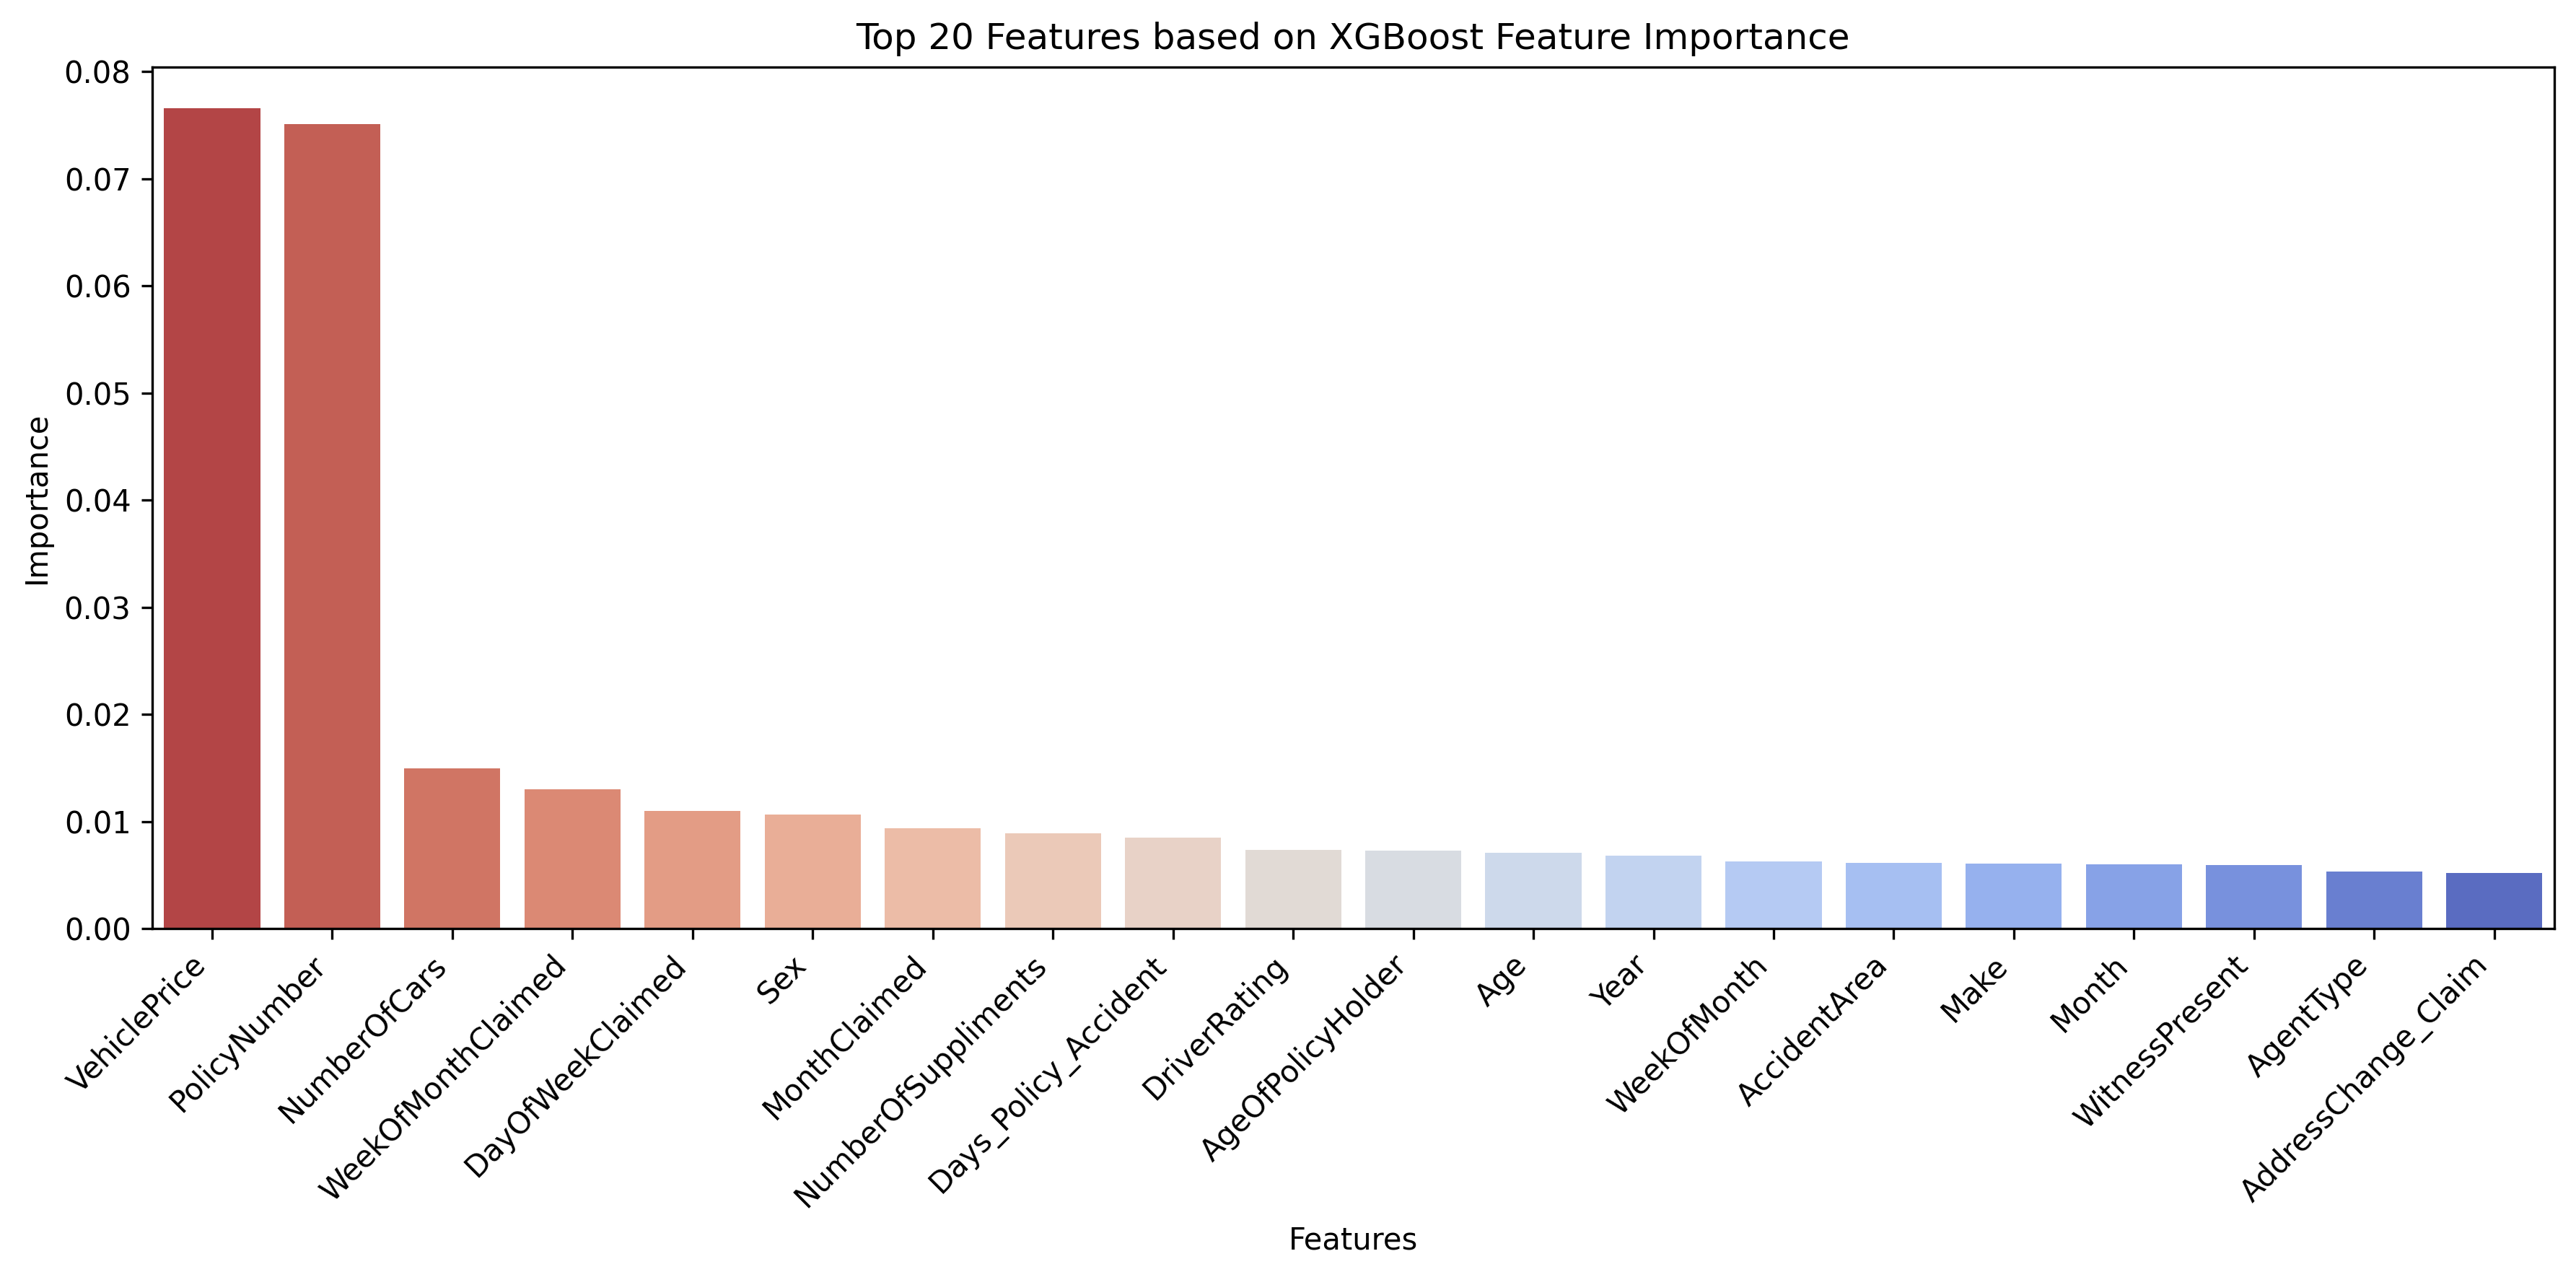

In [17]:
# Store XGBoost as the model
model = best_model

# Get feature importances using the "gain" metric
importances = model.feature_importances_

# Create a dictionary with the feature names and their respective importances
feature_scores = dict(zip(X_test.columns, importances))

# Sort the features based on their importances in descending order
sorted_features = {k: v for k, v in sorted(feature_scores.items(), key=lambda item: item[1], reverse=True)}

# Select the top 20 features based on their importances
top_features = list(sorted_features.keys())[:20]

# Create a color palette fading from crimson to blue
colors = sns.color_palette("coolwarm", len(top_features))[::-1]

# Create a bar plot for the top 20 features based on their importances
plt.figure(figsize=(12, 6), dpi=300)  # Increase DPI to 300
sns.barplot(x=top_features, y=[sorted_features[f] for f in top_features], palette=colors)
plt.title('Top 20 Features based on XGBoost Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis labels
plt.tight_layout()

# Display the plot
plt.show()

### 3.8 Save Model

Saving the model and preprocessing steps ensures reproducibility and facilitates seamless deployment, allowing for consistent and efficient utilization of the trained model.

In [18]:
# Specify the directory path to save the models
model_directory = "model"

# Create the model directory if it doesn't exist
os.makedirs(model_directory, exist_ok=True)

# Save the c_encoder
dump(c_encoder, os.path.join(model_directory, "c_encoder.joblib"))

# Save the b_encoder
dump(b_encoder, os.path.join(model_directory, "b_encoder.joblib"))

# Save the ord_encoder
dump(ord_encoder, os.path.join(model_directory, "ord_encoder.joblib"))

# Save the encoder
dump(o_encoder, os.path.join(model_directory, "o_encoder.joblib"))

# Save the scaler object
dump(scaler, os.path.join(model_directory, "scaler.joblib"))

# Save the best_model
dump(best_model, os.path.join(model_directory, "best_model.joblib"))

['model\\best_model.joblib']

### 3.9 Load Model

Loading the model enables easy access to the previously trained model's parameters and functionality, allowing for seamless integration into new applications or tasks.

In [19]:
# Load the c_encoder
c_encoder = load("model/c_encoder.joblib")

# Load the b_encoder
b_encoder = load("model/b_encoder.joblib")

# Load the ord_encoder
ord_encoder = load("model/ord_encoder.joblib")

# Load the encoder
o_encoder = load("model/o_encoder.joblib")

# Load the scaler object
scaler = load("model/scaler.joblib")

# Load the best_model
best_model = load("model/best_model.joblib")

### 3.10 Model Prediction

These code snippets allow for generating model predictions on new data.

#### Get new input

In [20]:
# Let's test the model inferencing by using first row of df
first_row = df.iloc[[0]] 
first_row = first_row.drop("FraudFound_P", axis=1)  # Drop the loan_status column

first_row.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability


#### Preprocess input

In [21]:
# Preprocess inputs
preprocessed_inputs = first_row.copy()

# Apply count encoding to categorical features
c_encoded_df = c_encoder.transform(preprocessed_inputs[high_cardinality_features])

# Apply binary encoding to binary features
b_encoded_df = b_encoder.transform(preprocessed_inputs[binary_features])

# Apply ordinal encoding to ordinal features
ord_encoded_df = ord_encoder.transform(preprocessed_inputs[ordinal_features])
# Convert the encoded features to a DataFrame
ord_encoded_df = pd.DataFrame(ord_encoded_df, columns=ordinal_features)

# Apply one-hot encoding to nominal features
o_encoded_df = o_encoder.transform(preprocessed_inputs[nominal_features])
# Convert the encoded features to a dense numpy array
o_encoded_df = o_encoded_df.toarray()
# Convert the dense numpy array to a DataFrame
o_encoded_df = pd.DataFrame(o_encoded_df, columns=o_encoder.get_feature_names_out(nominal_features))

# Combine the encoded features using pd.concat
preprocessed_inputs_encoded = pd.concat([c_encoded_df, b_encoded_df, ord_encoded_df, o_encoded_df], axis=1)

# Apply scaler to the encoded features
scaled_df = scaler.transform(preprocessed_inputs_encoded)
# Convert the scaled features to a DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=preprocessed_inputs_encoded.columns)

# Final preprocessed inputs
preprocessed_inputs = pd.DataFrame(scaled_df, columns=preprocessed_inputs_encoded.columns)

#### Predict output

In [22]:
# Make predictions using the best_model
predictions = best_model.predict(preprocessed_inputs)

# Extract the predicted class value
predicted_class = predictions[0]

# Print the predictions
print(predicted_class)

0


## 4. Conclusion

In conclusion, this Jupyter notebook presented various stages of the ML model development process for the vehicle insurance fraud detection dataset, including data preprocessing, model training and evaluation, and model interpretation. Amongst the Logistic Regression, Support Vector Machine, and XGBoost classifiers, the XGBoost classifier yielded the best performance and therefore, it is selected as the best model owing to its performance on precision, recall, and F1 score. Overall, having an F1 score of 1 on the training set and 0.95 on the validation and test sets is a good indication that the XGBoost model has learned to generalize well and is performing well.